<a href="https://colab.research.google.com/github/benwalkerdata/Portfolio-Python-Analysis/blob/main/house_price_salary_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>House Price and Average Salary analysis</h1>

by Ben Walker, 29 February 2024.

This is notebook analyse's a dataset from Kaggle which contains average house prices and salaries from 1975 to 2020.

In [74]:
#Module Imports
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
from scipy.stats import spearmanr
from matplotlib.gridspec import GridSpec

#Formatting Options
%matplotlib inline
%pip install --upgrade plotly
pd.options.display.float_format = '{:,.2f}'.format

<h2>Getting and preparing the data</h2>
The data has been obtained from Kaggle and includes average House prices and salaries in the UK between 1975 and 2020. In this section the dataset will be reviewed and cleaned to ensure the data is in a good state to analyse. Redundant columns will be removed, data types updated and the data will be checked for consistency.

The first two cells import the dataset from the CSV file and shows the top 5 rows.

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
#This provides a constant variable for the CSV.
LOCATION1 = '/content/drive/MyDrive/Data Analysis/House Prices and Salary/Average_UK_houseprices_and_salary.csv'
LOCATION2 = '/content/drive/MyDrive/Data Analysis/House Prices and Salary/Income_by_age_and_gender.csv'

In [77]:
#Create the dataframes and preview.
df_house = pd.read_csv(LOCATION1)
df_income = pd.read_csv(LOCATION2)
df_house.head(), df_income.head()

(   Year  Average house price adj. by inflation (pounds)  \
 0  1975                                           94983   
 1  1976                                           89281   
 2  1977                                           85028   
 3  1978                                          100519   
 4  1979                                          112067   
 
    Median Salary adj. by inflation (pounds)  Unnamed: 3  
 0                                       NaN         NaN  
 1                                       NaN         NaN  
 2                                       NaN         NaN  
 3                                       NaN         NaN  
 4                                       NaN         NaN  ,
   Age group  Median salary (pounds) Gender
 0  18 to 21                   18392   Male
 1  22 to 29                   26856   Male
 2  30 to 39                   34210   Male
 3  40 to 49                   38463   Male
 4  50 to 59                   36000   Male)

In [78]:
#Find column datatypes for df_house
print(df_house.dtypes)
print(df_income.dtypes)

Year                                                int64
Average house price adj. by inflation (pounds)      int64
Median Salary adj. by inflation (pounds)          float64
Unnamed: 3                                        float64
dtype: object
Age group                 object
Median salary (pounds)     int64
Gender                    object
dtype: object


In [79]:
#Change the "object" datatypes to something more useful, in this case String.
for column in df_income.columns:
    if df_income[column].dtype.kind == "O":
        df_income[column] = df_income[column].astype('string')
print(df_income.dtypes)

Age group                 string
Median salary (pounds)     int64
Gender                    string
dtype: object


In [99]:
#Find NULL values
df_house.isnull().sum(), df_income.isnull().sum()

(Year                                         0
 Average House Price                          0
 Median Salary adj. by inflation (pounds)    24
 dtype: int64,
 Age group                 0
 Median salary (pounds)    0
 Gender                    0
 dtype: int64)

In [82]:
#Review NULL values found in df_house
df_house.head(5)

,Year,Average house price adj. by inflation (pounds),Median Salary adj. by inflation (pounds),Unnamed: 3
0,1975,94983,NaN,NaN
1,1976,89281,NaN,NaN
2,1977,85028,NaN,NaN
3,1978,100519,NaN,NaN
4,1979,112067,NaN,NaN


As you can see from the df_house dataset above we do not have Median salary data for years 1975 to 2020. We also have a redundant column. in the following cells we will drop the redundant column and we will create a new dataset for the median salary just including data from 1999 to 2020.

In [83]:
#Drop redundant column from dataset
df_house = df_house.drop('Unnamed: 3', axis=1)
print(df_house.columns)

Index(['Year', 'Average house price adj. by inflation (pounds)',
       'Median Salary adj. by inflation (pounds)'],
      dtype='object')


In [84]:
#Combine the dataframes for years after 1999
df_salary = df_house.loc[df_house['Year'] >= 1999]
df_salary = df_salary.drop('Average house price adj. by inflation (pounds)', axis=1)
df_salary.head()

,Year,Median Salary adj. by inflation (pounds)
24,1999,"31,551.55"
25,2000,"32,443.92"
26,2001,"33,357.50"
27,2002,"33,898.44"
28,2003,"34,155.19"


In [85]:
#Rename Average House price column
df_house = df_house.rename(columns={"Average house price adj. by inflation (pounds)": "Average House Price"})
df_house.head()

,Year,Average House Price,Median Salary adj. by inflation (pounds)
0,1975,94983,NaN
1,1976,89281,NaN
2,1977,85028,NaN
3,1978,100519,NaN
4,1979,112067,NaN


We now have three datasets. df_house which provides the average house prices for years 1975 to 2020. df_salary which provides median salary between years 1999 and 2020. Finally we have df_income which contains median salary vs age group and male/female.

<h1>Analysis</h1>

The following questions will be answered in this section of the analysis.
<ul>
    <li>How have house prices changed over time?</li>
    <li>How have Salaries changed over time?</li>
    <li>Is there any correlation between average house prices and average salaries?</li>
    <li>How do salaries for males differ from salaries for females?</li>
    <li>How do salaries change by age group?</li>
    <li>How do salaries for age groups compare between males and females?</li>
    <li>What the multiplication factor of salary to house price?</li>
    <li>How has the multiplication factor changed over time?</li>
</ul>

The following cells will analyse the data to produce answers to the questions above.

In [86]:
df_salary = df_salary.rename(columns={"Median Salary adj. by inflation (pounds)": "Average Salary"})
#df_salary = df_salary.set_index("Year")

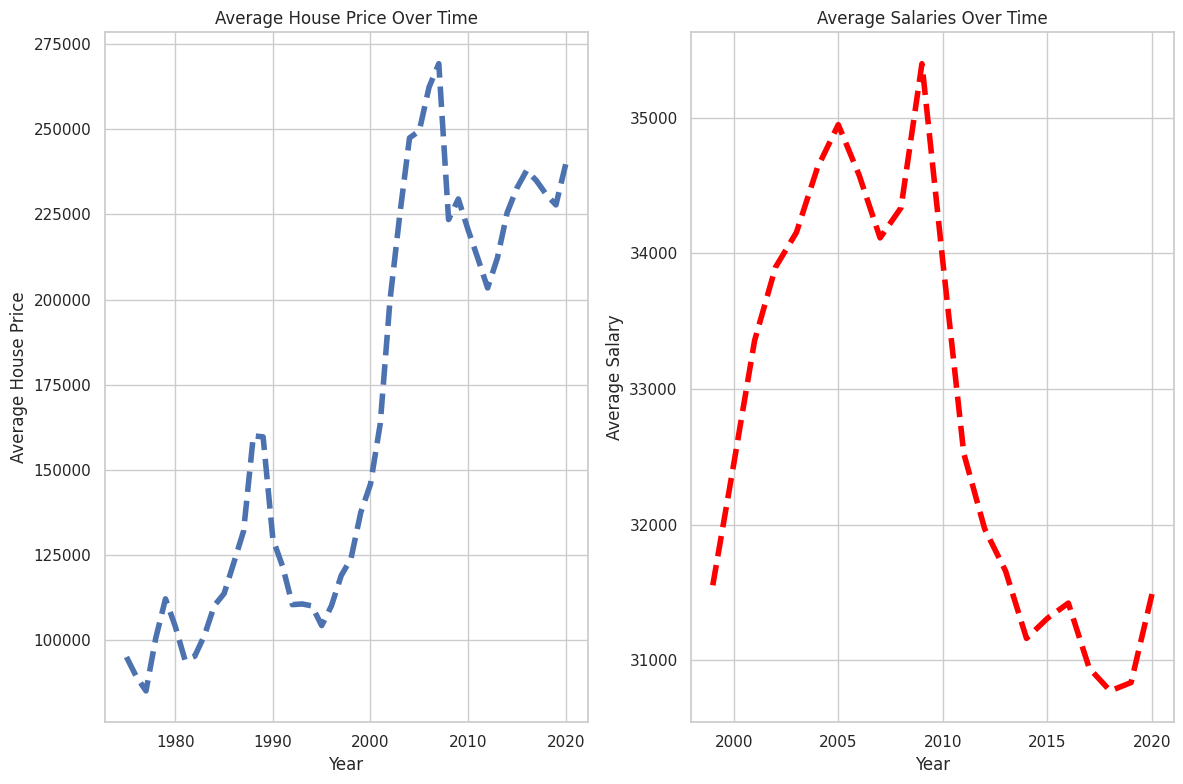

In [87]:
#Set figure size
flt = plt.figure(figsize=(12,8))

#Set Grid size
gs= GridSpec(1,2)

#Create subplots
plot1 = plt.subplot(gs[0])
plot2 = plt.subplot(gs[1])

#Create plots
plot1.plot(df_house['Year'], df_house['Average House Price'], linestyle='dashed', linewidth=4)
plot2.plot(df_salary['Year'], df_salary['Average Salary'], color="red", linestyle='dashed', linewidth=4)

#Add labels and titles
plot1.set_xlabel('Year')
plot1.set_ylabel('Average House Price')
plot1.set_title("Average House Price Over Time")

plot2.set_xlabel('Year')
plot2.set_ylabel('Average Salary')
plot2.set_title('Average Salaries Over Time')

#Adjust the layout
plt.tight_layout()
#Show the plots
plt.show()

In [88]:
#create filtered DF containing average house price and median salary
df_house_filtered = df_house.query("Year >= 1999")

print(df_house_filtered)

    Year  Average House Price  Median Salary adj. by inflation (pounds)
24  1999               137401                                 31,551.55
25  2000               145756                                 32,443.92
26  2001               163517                                 33,357.50
27  2002               199821                                 33,898.44
28  2003               224849                                 34,155.19
29  2004               247493                                 34,630.76
30  2005               249549                                 34,950.06
31  2006               262390                                 34,576.58
32  2007               269297                                 34,114.51
33  2008               223507                                 34,337.23
34  2009               229553                                 35,399.83
35  2010               220496                                 33,938.03
36  2011               212111                                 32

In [89]:
#Check to see whether there is any correlation between average house price and average salary
correlation = np.corrcoef(df_house_filtered["Average House Price"], df_salary["Average Salary"])[0, 1]
(correlation, pValue) = spearmanr(df_house_filtered["Average House Price"], df_salary["Average Salary"])
print('The correlation is', correlation)
if pValue < 0.05:
    print('It is statistically significant.')
else:
    print('It is not statistically significant.')

The correlation is 0.13833992094861663
It is not statistically significant.


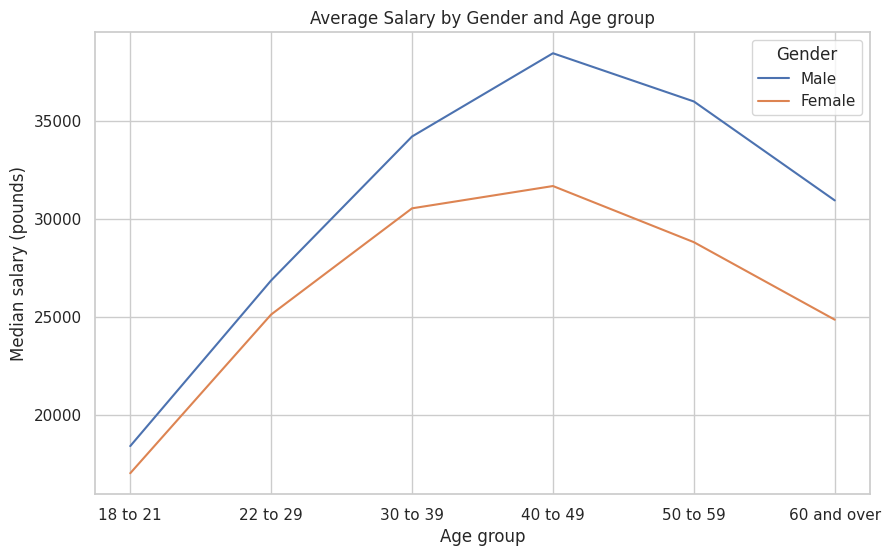

In [90]:
#A plot showing
fig = plt.figure(figsize=(10,6))
sns.lineplot(x="Age group", y="Median salary (pounds)", hue="Gender", data=df_income)
plt.legend(title="Gender")
plt.title("Average Salary by Gender and Age group")
plt.show()

In [94]:
#Calculate the multiplication factor
df_house_filtered.loc[:,'multi_factor'] = df_house_filtered['Average House Price'] / df_house_filtered['Median Salary adj. by inflation (pounds)']

<ipython-input-94-264c6dd14955>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_house_filtered.loc[:,'multi_factor'] = df_house_filtered['Average House Price'] / df_house_filtered['Median Salary adj. by inflation (pounds)']


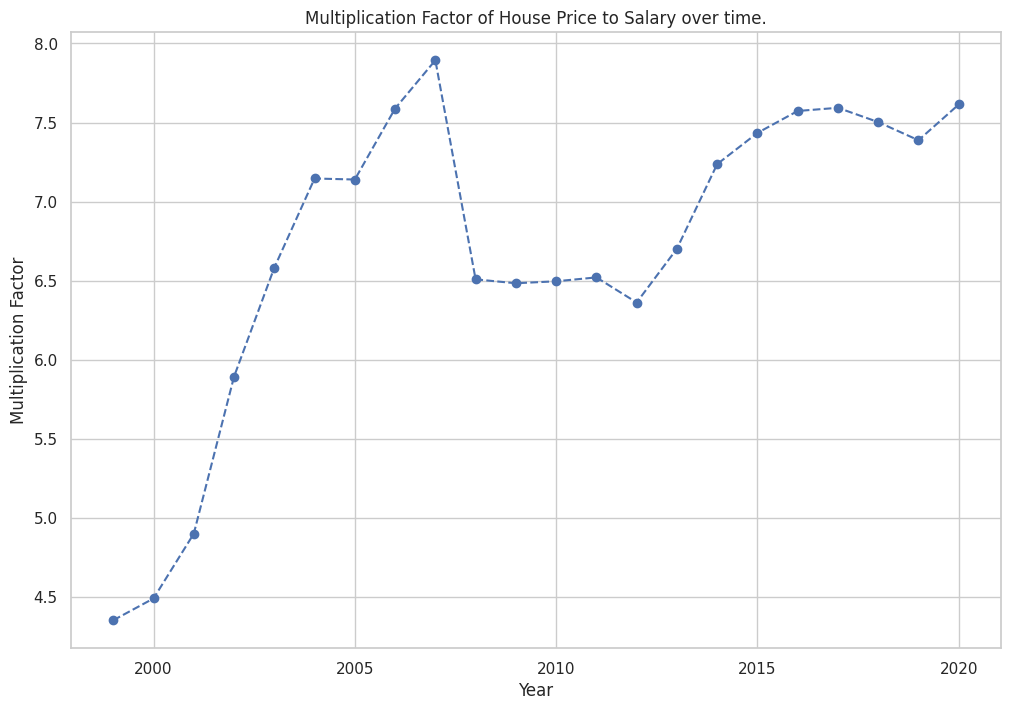

In [98]:
#Plot to show multiplication factor over time
plt.figure(figsize=(12, 8))
plt.plot(df_house_filtered['Year'], df_house_filtered['multi_factor'], marker='o', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Multiplication Factor')
plt.title('Multiplication Factor of House Price to Salary over time.')

plt.show()